In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from scipy.interpolate import UnivariateSpline

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
# Parametros fijos del problema
#
# Datos de Concentracion del trazador en mmol/L vs tiempo en min 
c = np.array([1.00, 1.005, 1.02, 1.06, 1.20, 1.41, 1.61, 1.77, 1.92, 1.96, 2.00])
t = np.array([0, 5, 10, 15, 20, 30, 45, 60, 90, 120, 150])

# Calculo de la curva de distribucion acumulativa
## La funcion distribucion acumulativa F(t)

In [4]:
F = (c - c[0])/(c[-1] - c[0]) 

## Calculo de la curva E(t)


### Using forward differencing tecnique

\begin{equation*}
E(t) = \frac{F(t)}{dt} = \frac{F_{i+1} - F_{i}}{t_{i+1} - t_{i}}
\end{equation*}

In [5]:
E_forward = [(F[i+1] - F[i]) / (t[i+1] - t[i]) for i in range(0, len(F)-1)]

### Using central differencing tecnique

\begin{equation*}
E(t) = \frac{F(t)}{dt} = \frac{F_{i+1} - F_{i-1}}{t_{i+1} - t_{i-1}}
\end{equation*}

In [6]:
E_central = [(F[i+1] - F[i-1])/(t[i+1] - t[i-1]) for i in range(1, len(F)-1)]

### Using curve fitting tecnique

In [7]:
spl = UnivariateSpline(t, F, s=0)

t_adj = np.linspace(0, 150, 100)
F_adj = spl(t_adj)

In [8]:
E_adj = np.diff(F_adj)/np.diff(t_adj)

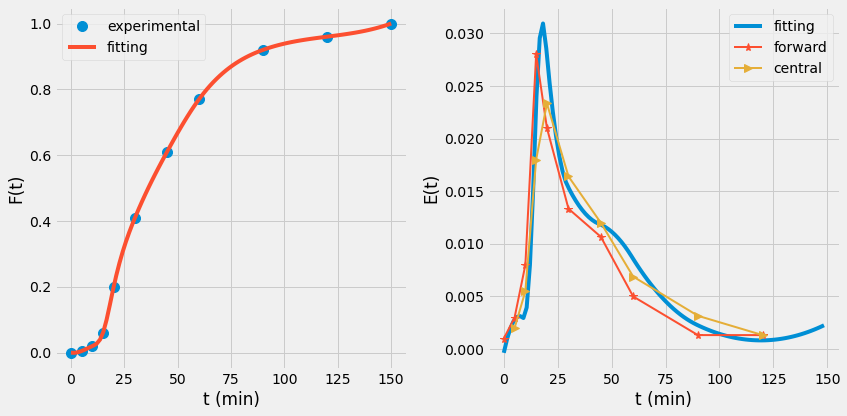

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(t, F, markersize=10, marker='o', ls='None',
        label='experimental')
ax1.plot(t_adj, F_adj, label='fitting') 

ax1.set_xlabel('t (min)') 
ax1.set_ylabel('F(t)') 
ax1.legend(loc='best')

ax2.plot(t_adj[0:-1], E_adj, label='fitting') 
ax2.plot(t[0:-1], E_forward, markersize=8, marker='*', lw=2, label='forward') 
ax2.plot(t[1:-1], E_central, markersize=8, marker='>', lw=2, label='central') 

ax2.set_xlabel('t (min)') 
ax2.set_ylabel('E(t)') 

ax2.legend(loc='best')
plt.tight_layout()
plt.show()

# Calculating the first and second moments

## First Moment

In [10]:
tmean_forward = trapezoid(t[0:-1]* E_forward, t[0:-1]) 
tmean_fitting = trapezoid(t_adj[0:-1]* E_adj, t_adj[0:-1]) 
tmean_central = trapezoid(t[1:-1]* E_central, t[1:-1]) 

 
print('El tiempo medio de residencia (forward) es igual a {:1.3f} min'.format(tmean_forward))
print('El tiempo medio de residencia (fitting) es igual a {:1.3f} min'.format(tmean_fitting))
print('El tiempo medio de residencia (central) es igual a {:1.3f} min'.format(tmean_central))

El tiempo medio de residencia (forward) es igual a 30.675 min
El tiempo medio de residencia (fitting) es igual a 43.396 min
El tiempo medio de residencia (central) es igual a 39.650 min


## Second Moment

In [11]:
def cal_ntanks(t, ecurve, tmean):
    variance = trapezoid(t**2 * ecurve, t) - tmean**2
    ntanks = math.ceil(tmean**2 / variance)
    return ntanks

In [12]:
ntanks_forward = cal_ntanks(t[0:-1], E_forward, tmean_forward)
ntanks_central = cal_ntanks(t[1:-1], E_central, tmean_central)
ntanks_fitting = cal_ntanks(t_adj[0:-1], E_adj, tmean_fitting)

# Which technique is the best?

From F curve is possible to calculate the C(t) based on the number of tanks and we can compare the results with the original C(t) curve

\begin{equation}
\mathbf{F}_N(\theta) = 1 - \exp \left(-N\,\theta\right)\,\sum\limits_{i=0}^{N-1}{\frac{(N\theta)^i}{i!}}
\end{equation}

\begin{equation}
c(t) = c(0) + \mathbf{F}(t)\,\left( C(\infty) - c(0) \right)
\end{equation}


In [13]:
from sympy.utilities.lambdify import lambdify
from sympy.functions import exp
from sympy import Sum, factorial, symbols

def funcion_F(ntanks):
    theta = symbols("theta", real=True)
    i = symbols("i", integer=True)
    f = 1 - exp(-ntanks*theta) * Sum((ntanks*theta)**i/factorial(i), (i, 0, ntanks-1)).doit()
    fnumerical = lambdify(theta, f)
    return fnumerical

In [14]:
time = np.linspace(0, 150) 
thetaC = time/tmean_central 
Fcalccentral = funcion_F(ntanks_central) 
Calccentral = c[0] + (c[-1] - c[0]) * Fcalccentral(thetaC) 

thetaF = time/tmean_forward 
Fcalcforward = funcion_F(ntanks_forward) 
Calcforward =  c[0] + (c[-1] - c[0]) * Fcalcforward(thetaF) 


thetaFit = time/tmean_fitting 
FcalcFit = funcion_F(ntanks_fitting) 
CalcFit =  c[0] + (c[-1] - c[0]) * FcalcFit(thetaF) 

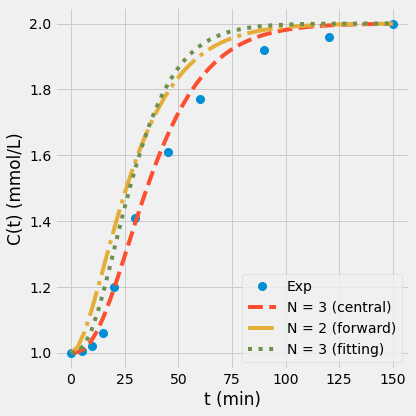

In [15]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(t, c, markersize=8, marker='o', ls='None', label='Exp')
ax.plot(time, Calccentral, ls='--', 
        label = ('N = %d (central)'% ntanks_central))
ax.plot(time, Calcforward, ls='-.', 
        label = ('N = %d (forward)'% ntanks_forward)) 
ax.plot(time, CalcFit, ls=':', 
        label = ('N = %d (fitting)'% ntanks_fitting)) 

ax.set_xlabel('t (min)') 
ax.set_ylabel('C(t) (mmol/L)')
plt.legend(loc='best')

plt.tight_layout()
plt.show()